In [1]:
try:
    import probml_utils as pml
    from probml_utils import savefig, latexify,is_latexify_enabled
except ModuleNotFoundError :
    %pip install git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    from probml_utils import savefig, latexify,is_latexify_enabled
try:
    from sklearn.datasets import make_classification
except ModuleNotFoundError:
    %pip install -qq scikit-learn
    from sklearn.datasets import make_classification
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import seaborn as sns

In [2]:
latexify(width_scale_factor=2, fig_height=2)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


In [3]:
def make_data(ntrain, ntest):
    n = ntrain + ntest
    X, y = make_classification(
        n_samples=n, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, class_sep=0.1, random_state=1
    )
    Xtrain = X[:ntrain, :]
    ytrain = y[:ntrain]
    Xtest = X[ntrain:, :]
    ytest = y[ntrain:]
    xmin = jnp.min(X[:, 0])
    xmax = jnp.max(X[:, 0])
    ymin = jnp.min(X[:, 1])
    ymax = jnp.max(X[:, 1])
    xx, yy = jnp.meshgrid(jnp.linspace(xmin, xmax, n), jnp.linspace(ymin, ymax, 200))
    return Xtrain, ytrain, Xtest, ytest, xx, yy

In [5]:
def plot_data(ax, X, y, is_train=True):
    X0 = X[:, 0]
    X1 = X[:, 1]
    colors = ["blue","red"]
    if is_train:
        markers = ["*", "x"]
    else:
        markers = ["s", "o"]
    for i in range(0,2):
      ax.plot(X[y==i, 0], X[y==i, 1], color=colors[i],marker=markers[i], linestyle = 'None', label="Class {}".format(i))
    ax.set_ylim(-2.75, 2.75)
    plt.legend(title='Ground Truth',loc='upper right')
    plt.xlabel('$x_{0}$')
    plt.ylabel('$x_{1}$')
    sns.despine()

In [6]:
def plot_predictions(ax, xx, yy, transformer, model):
    grid = jnp.c_[xx.ravel(), yy.ravel()]
    grid2 = transformer.transform(grid)[:, 1:]
    Z = model.predict(grid2).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.55)

In [7]:
ntrain = 50
ntest = 1000
Xtrain, ytrain, Xtest, ytest, xx, yy = make_data(ntrain, ntest)


In [8]:
def train_plot():
  C_list = jnp.logspace( 0, 5, 7)
  degree=4
  plot_list_C=[1,316,100000]
  err_train_list = []
  err_test_list = []
  weights_list = []
  for i, C in enumerate(C_list):
    transformer = PolynomialFeatures(degree)
    Xtrain_poly_feature = transformer.fit_transform(Xtrain)[:, 1:] 
    model = LogisticRegression(C=int(C))
    model = model.fit(Xtrain_poly_feature, ytrain)
    weight = model.coef_[0]
    weights_list.append(weight)
    ytrain_pred = model.predict(Xtrain_poly_feature)
    nerrors_train = jnp.sum(ytrain_pred != ytrain)
    err_train_list.append(nerrors_train / ntrain)
    Xtest_poly_feature = transformer.fit_transform(Xtest)[:, 1:]  
    ytest_pred = model.predict(Xtest_poly_feature)
    nerrors_test = jnp.sum(ytest_pred != ytest)
    err_test_list.append(nerrors_test / ntest)

    if int(C) in plot_list_C:
      
        fig, ax = plt.subplots()
        name = "Inv Reg (C) = {:d}, Degree = {}".format(int(C), degree)
        plot_predictions(ax, xx, yy, transformer, model)
        plot_data(ax, Xtrain, ytrain, is_train=True)
        ax.set_title(name)
        savefig('log_reg_poly_InvReg_{:d}_deg_{:d}_latexified'.format(int(C),degree))
        plt.draw()
      
        
  plt.figure()
  plt.plot(C_list, err_train_list, "x-", label="train")
  plt.plot(C_list, err_test_list, "o-", label="test")
  plt.legend()
  plt.xscale("log")
  plt.ylim(0,0.5)
  plt.xlabel("Inverse regularization")
  plt.title('Train and Test Error v/s C')
  plt.ylabel("Error Rate")
  savefig("Train & Test Error vs C,degree_{}_latexified".format(degree))
  sns.despine()
  plt.show()


/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818:

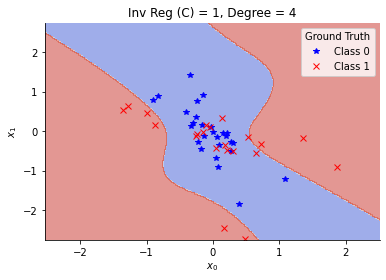

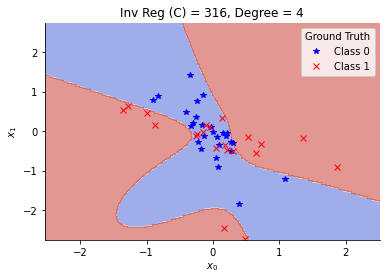

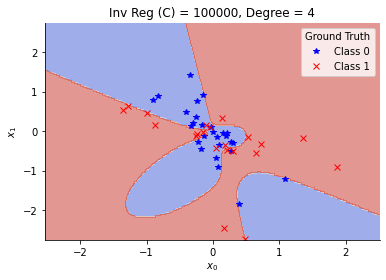

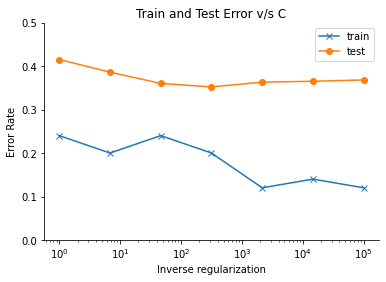

In [9]:
train_plot()